In [66]:
#installing kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
#make directory
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [68]:
#json file
! cp kaggle.json ~/.kaggle/

In [69]:
#chmod
! chmod 600 ~/.kaggle/kaggle.json

In [70]:
#download dataset
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [71]:
#unzip images
! unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [72]:
# importing necessary libraries
import numpy as np
import pandas as pd 
import random as rn

# import tensorflow libraries
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# import all data visualization and chart creation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# importing the image scanning libraries
from skimage import color, exposure
from sklearn.metrics import classification_report


# importing libraries needed to manipulate file directory libraries for saving checkpoints
import os
import cv2


# seed for repetition

seed = 80

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# matplotlib to display graphs in jupyter notebook
%matplotlib inline

print("All libraries successfully imported!")

All libraries successfully imported!


In [73]:
# the path needed where source data is located once taken from the kaggle
data_path = '/content/chest_xray/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

# Compressing the image size to conserve processsing cost and expediate model prediction.
img_size = 100

In [74]:
#Function for reading data from folders.
#Returns numpy array [img, label]
labels = ['PNEUMONIA', 'NORMAL']

def read_data(data_paths):
    for data_path in data_paths:
        images = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [75]:
# Seperating training and test data. Test and validation were merge together as the validation folder only contained 16 images
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [76]:
# Shuffling the dataset 10 times.
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [77]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [90]:
train_df['label'].head(10)

0    PNEUMONIA
1    PNEUMONIA
2    PNEUMONIA
3    PNEUMONIA
4    PNEUMONIA
5    PNEUMONIA
6       NORMAL
7    PNEUMONIA
8       NORMAL
9    PNEUMONIA
Name: label, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


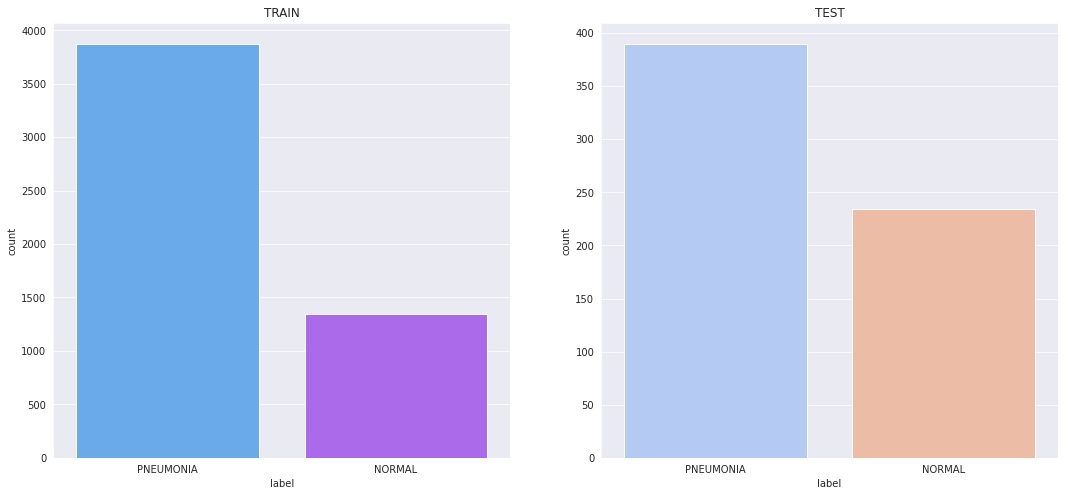

In [79]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'cool')
plt.title('TRAIN')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "coolwarm")
plt.title('TEST')

plt.show()

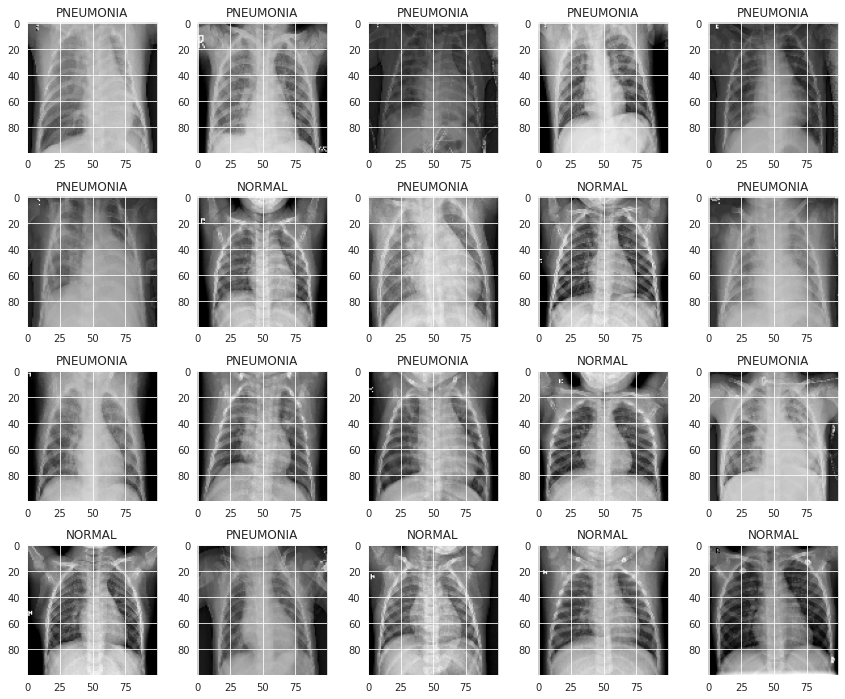

In [80]:
def Show_example_image():
    fig = plt.figure(figsize = (12, 12))
    for idx in range(20):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

# Data preprocessing

In [81]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

#dividing data into 2 arrays.. x and y
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

# splitting the data
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

#  converting to grayscale, normalizing, and reshaping the table
def preprocesing(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # normalizing data
    data1 /= 255
    
    return data1

#Function to drawing learning curve history learning neural network
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='best')
    plt.show()


In [82]:
X_train = preprocesing(X_train)
X_test = preprocesing(X_test)

In [83]:
num_pixels = X_train.shape[1] 

# one-hot encoding target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [84]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('/content/working/model.best1.hdf5',monitor='loss', save_best_only=True) # this line is saving the best model ran
]

#### First model

In [85]:
def model1():
    
    return Sequential([
        #input layer is automatically generated from keras
        
        # defining hidden layers
        Dense(10, input_dim = num_pixels, activation='relu'),
        Dense(500, input_dim = num_pixels, activation='relu'),
        Dense(1024, input_dim = num_pixels, activation='relu'),

        #defining the output layer
        Dense(num_classes, activation='softmax')
    ])

In [86]:
model = model1()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                100010    
                                                                 
 dense_9 (Dense)             (None, 500)               5500      
                                                                 
 dense_10 (Dense)            (None, 1024)              513024    
                                                                 
 dense_11 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 620,584
Trainable params: 620,584
Non-trainable params: 0
_________________________________________________________________


In [87]:
#Fitting the model
learning_history = model.fit(X_train, y_train,
          batch_size = 80, epochs = 75, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/75
66/66 - 1s - loss: 0.5703 - accuracy: 0.7360 - val_loss: 0.6337 - val_accuracy: 0.6250 - lr: 0.0010 - 1s/epoch - 19ms/step
Epoch 2/75
66/66 - 1s - loss: 0.3178 - accuracy: 0.8612 - val_loss: 0.4756 - val_accuracy: 0.7853 - lr: 0.0010 - 1s/epoch - 19ms/step
Epoch 3/75
66/66 - 1s - loss: 0.2243 - accuracy: 0.9099 - val_loss: 0.3482 - val_accuracy: 0.8381 - lr: 0.0010 - 1s/epoch - 18ms/step
Epoch 4/75
66/66 - 1s - loss: 0.1621 - accuracy: 0.9394 - val_loss: 0.3368 - val_accuracy: 0.8462 - lr: 0.0010 - 1s/epoch - 18ms/step
Epoch 5/75
66/66 - 1s - loss: 0.1575 - accuracy: 0.9335 - val_loss: 0.6767 - val_accuracy: 0.7564 - lr: 0.0010 - 1s/epoch - 17ms/step
Epoch 6/75
66/66 - 1s - loss: 0.1415 - accuracy: 0.9463 - val_loss: 0.4678 - val_accuracy: 0.8125 - lr: 0.0010 - 1s/epoch - 19ms/step
Epoch 7/75
66/66 - 1s - loss: 0.1293 - accuracy: 0.9507 - val_loss: 0.5019 - val_accuracy: 0.8093 - lr: 0.0010 - 1s/epoch - 17ms/step
Epoch 8/75
66/66 - 1s - loss: 0.1243 - accuracy: 0.9525 - val_

In [89]:
# loading the best model in terms of the loss metric
model = load_model('/content/working/model.best1.hdf5')

#evaluating the model
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 119.44690942764282%
Test accuracy: 75.16025900840759%
MLP Error: 24.84%


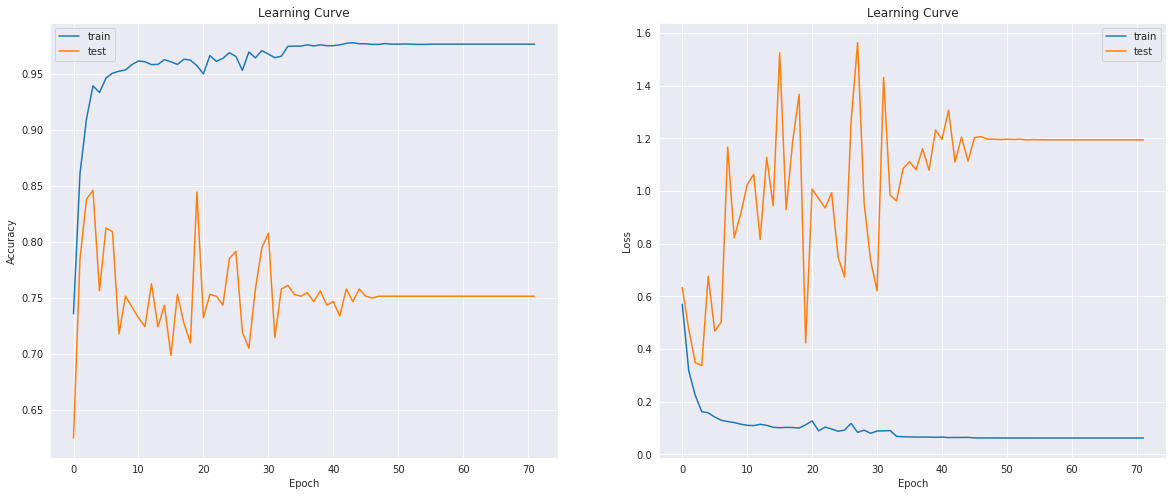

In [88]:
draw_learning_curve(learning_history)

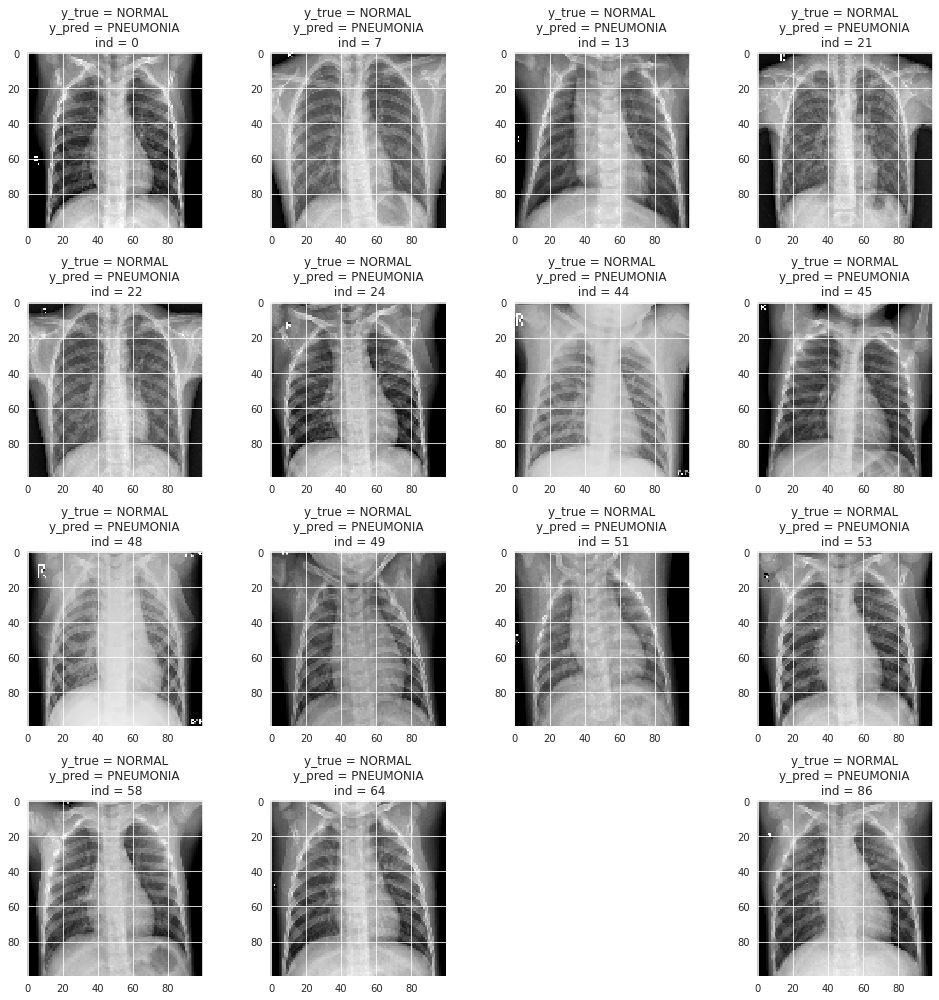

In [95]:
# viewing xrays
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

### Results

In [96]:
# assessing the model's predictions
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.35      0.52       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



In [122]:
# creating the confusion matrix
def confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  
    # plotting using heatmap
    # creating text in each square
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # generate summary
    if sum_stats:
        #Accuracy = diagonal sum / total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

#setting parameters
    if figsize==None:
        #default
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #if x & y are is False, no categories show
        categories=False


    # creating a heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


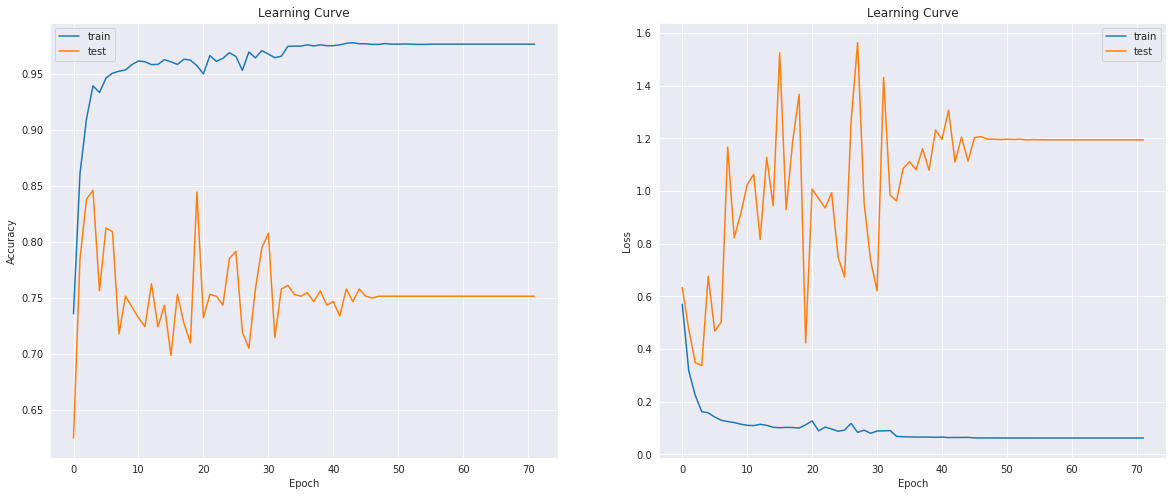

In [123]:
draw_learning_curve(learning_history)